In [1]:
import pandas as pd
import spacy
import re
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import math
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk import bigrams
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns; sns.set()
sns.set_style("white")
%matplotlib inline

In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

/Users/kunalgusain/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
from nltk.text import Text

In [4]:
STOPLIST = set(list(ENGLISH_STOP_WORDS) + ["india", "country", "government", "today", "new", "year", "nation", "people", "brother", "sister", "make"]) 

In [5]:
nlp = spacy.load('en_core_web_sm')

In [6]:
df = pd.read_csv("independence_day_speech_data_2000_2017.csv")

In [7]:
df.head()

,year,speech
0,2004,\n\r\n Text of Prime Minister’s...
1,2005,\n\r\n Text of Prime Minister’s...
2,2006,\n\r\n Text of Prime Minister’s...
3,2007,\n\r\n Text of Prime Minister’s...
4,2008,\n\r\n PM’s address on 62nd Ind...


In [8]:
def cleanText(text):
    # Remove New Lines
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    #Remove All Special Characters
    text = re.sub(r'\W+', ' ', text)
    return text

def tokenizeText(text):
    doc = nlp(text)
    # Removing Whitespaces
    tokens = [token for token in doc if not token.is_space]
    # Lemmatize
    tokens = [token.lemma_.lower().strip() if token.lemma_ != "-PRON-" else token.lower_ for token in tokens]
    # Removing Stop Words
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    # remove large strings of whitespace
    while "" in tokens:
        tokens.remove("")
    while " " in tokens:
        tokens.remove(" ")
    while "\n" in tokens:
        tokens.remove("\n")
    while "\n\n" in tokens:
        tokens.remove("\n\n")
    return " ".join(tokens)

def getSpeechBigrams(speech):
    speech_splitted = speech.split(" ")
    speech_bigram_tuples_list = bigrams(speech_splitted)
    bigram_speech_text = ''
    for x,y in speech_bigram_tuples_list:
        bigram_speech_text+='{}_{} '.format(x, y)
    return bigram_speech_text.strip() 

In [9]:
df["speech"] = df["speech"].apply(cleanText)
df["speech"] = df["speech"].apply(tokenizeText)
df['speech_bigrams'] = df['speech'].apply(getSpeechBigrams)

In [10]:
term_1_abb = [2000, 2001, 20002, 20003]
term_2_mms = [2004, 2005, 2006, 2007, 2008]
term_3_mms = [2009, 2010, 2011, 2012, 2013]
term_4_nm = [2014, 2015, 2016, 2017]

In [11]:
total_years = df.shape[0]

In [12]:
df = df.sort_values(by="year", ascending=True).reset_index(drop=True)

In [13]:
## Year on year wordclouds
n_cols = 2
n_rows = math.ceil(total_years/n_cols)

## Speech Lenghts

In [21]:
df['speech_length'] = df['speech'].apply(lambda x: len(str(x.split(" "))))

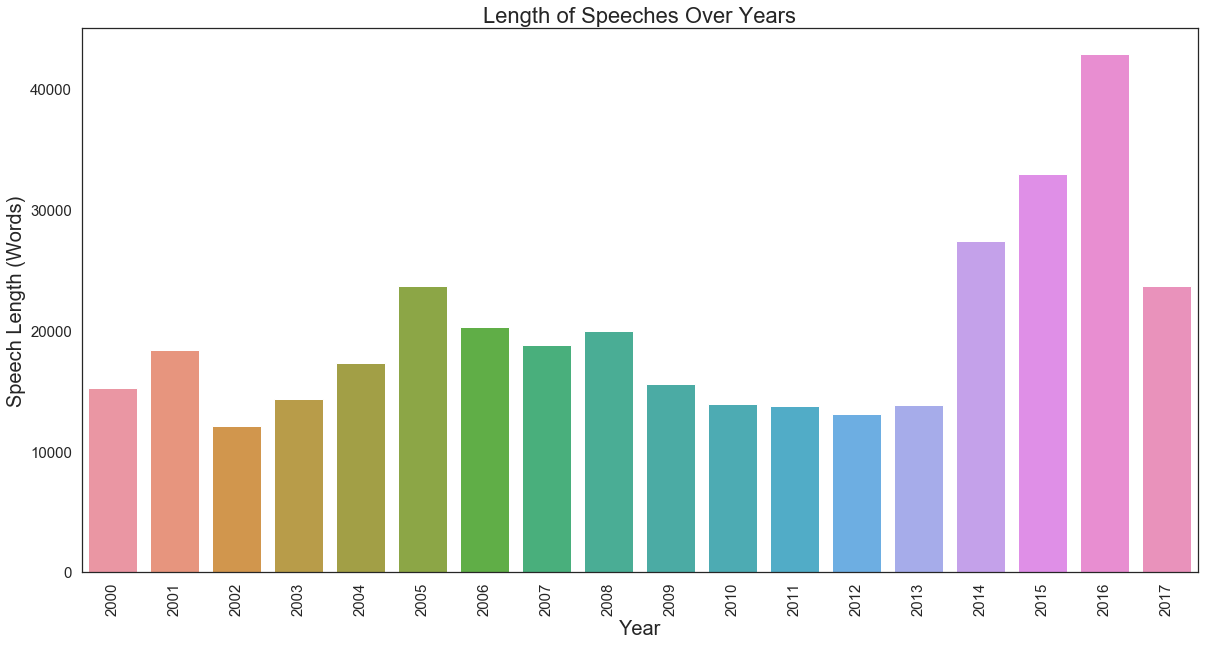

In [15]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x=df.year.values, y=df.speech_length)
ax.set_title("Length of Speeches Over Years", fontsize=22)
ax.set_ylabel("Speech Length (Words)", fontsize=20);
ax.set_xlabel("Year", fontsize=20);
ax.set_xticklabels(df.year.values, rotation=90, fontsize=15);
ax.yaxis.set_tick_params(labelsize=15);
# plt.savefig('Speech_Length.png', bbox_inches='tight', dpi=300)

## Wordclouds of Different Governments

In [17]:
ab_speeches = " ".join(df[df.year.isin(term_1_abb)]['speech'].values)
mm1_speeches = " ".join(df[df.year.isin(term_2_mms)]['speech'].values)
mm2_speeches = " ".join(df[df.year.isin(term_3_mms)]['speech'].values)
nm_speeches = " ".join(df[df.year.isin(term_4_nm)]['speech'].values)

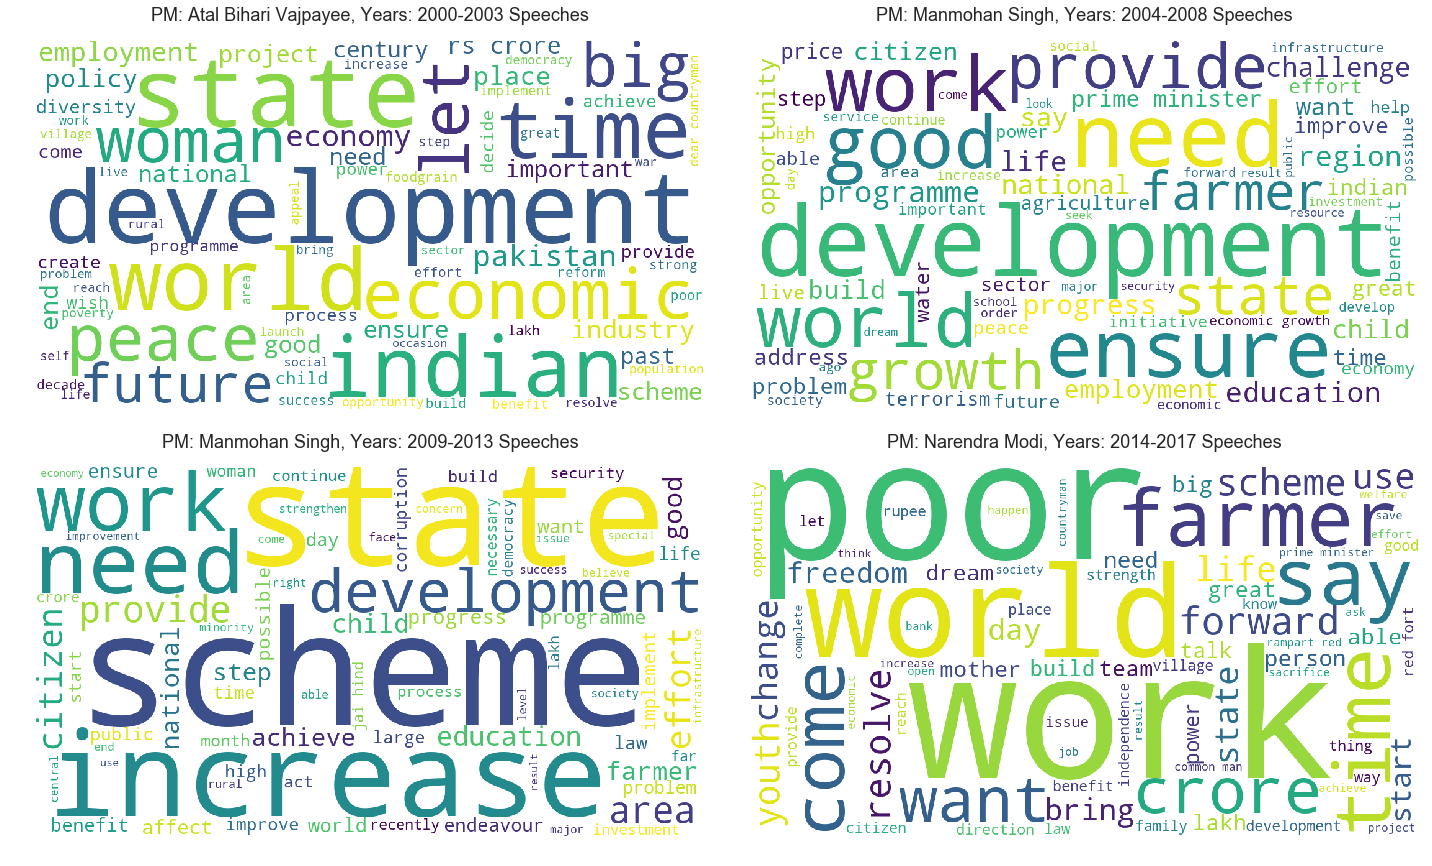

In [110]:
fig = plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
cloud = WordCloud(background_color="white", width=1080, height=600, max_words=75).generate(ab_speeches)
plt.title("PM: Atal Bihari Vajpayee, Years: 2000-2003 Speeches", fontsize=18, pad=20)
plt.imshow(cloud)
plt.axis('off');

plt.subplot(2, 2, 2)
cloud = WordCloud(background_color="white", width=1080, height=600, max_words=75).generate(mm1_speeches)
plt.title("PM: Manmohan Singh, Years: 2004-2008 Speeches", fontsize=18, pad=20)
plt.imshow(cloud)
plt.axis('off');

plt.subplot(2, 2, 3)
cloud = WordCloud(background_color="white", width=1080, height=600, max_words=75).generate(mm2_speeches)
plt.title("PM: Manmohan Singh, Years: 2009-2013 Speeches", fontsize=18, pad=20)
plt.imshow(cloud)
plt.axis('off');

plt.subplot(2, 2, 4)
cloud = WordCloud(background_color="white", width=1080, height=600, max_words=75).generate(nm_speeches)
plt.title("PM: Narendra Modi, Years: 2014-2017 Speeches", fontsize=18, pad=20)
plt.imshow(cloud)
plt.axis('off');
plt.tight_layout()
# plt.savefig('PM_term_wordclouds.png', bbox_inches='tight', dpi=300)

## Wordclouds through the years

In [ ]:
# Wordclouds through the years
# fig = plt.figure(figsize=(20, 60), dpi=300)
fig = plt.figure(figsize=(20, 60))
for _tuple in df.itertuples():
    _idx = _tuple[0]
    _year = _tuple[1]
    _speech = _tuple[2]
    plt.subplot(n_rows, n_cols, _idx+1)
    cloud = WordCloud(background_color="white", width=1080//2, height=600//2, max_words=75).generate(_speech)
    plt.title("Year: {}".format(_year), fontsize=22)
    plt.imshow(cloud)
    plt.axis('off');
plt.tight_layout()
# plt.savefig('unigram_wordclouds_over_years_2.png', bbox_inches='tight', dpi=300)

## Bigram WordCloud

In [ ]:
# Wordclouds through the years
fig = plt.figure(figsize=(20, 60))
# fig = plt.figure(figsize=(20, 60), dpi=300)
for _tuple in df.itertuples():
    _idx = _tuple[0]
    _year = _tuple[1]
    _speech = _tuple[3]
    plt.subplot(n_rows, n_cols, _idx+1)
    cloud = WordCloud(background_color="white", width=1080//2, height=600//2, max_words=75).generate(_speech)
    plt.title("Year: {}".format(_year), fontsize=22)
    plt.imshow(cloud)
    plt.axis('off');
plt.tight_layout()
# plt.savefig('bigram_wordclouds_over_years_2.png', bbox_inches='tight', dpi=300)

## Single Unigram Wordcloud for last 20 years

In [34]:
all_speeches = df['speech'].values.tolist()
all_speeches_combined = " ".join(all_speeches)

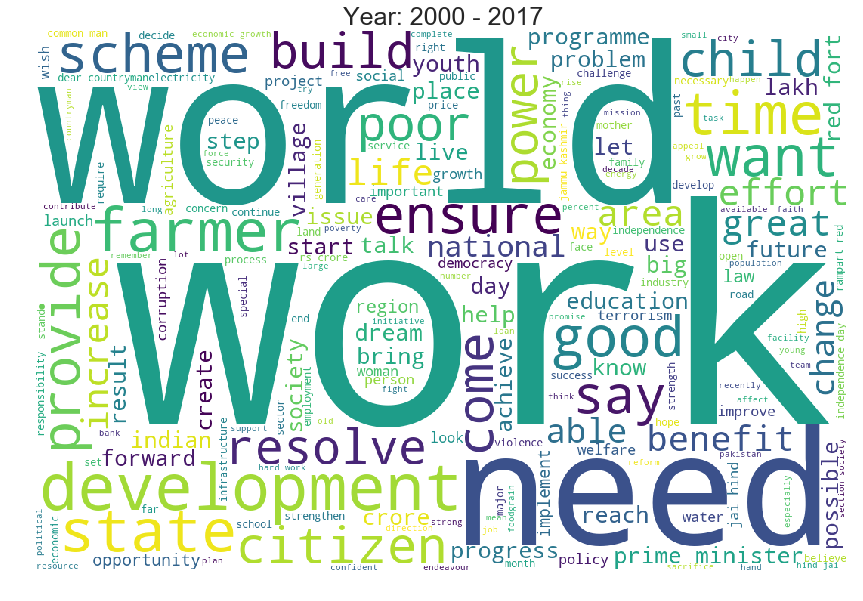

In [35]:
unigram_wordcloud = WordCloud(width=1080, height=720, background_color="white").generate(all_speeches_combined)
plt.figure(figsize=(20,10))
# plt.figure(figsize=(20,10), dpi=1000)
plt.imshow(unigram_wordcloud)
plt.axis('off')
plt.title("Year: 2000 - 2017", fontsize=25);
# plt.savefig('single_unigram_wordcloud_over_years.png', bbox_inches='tight', dpi=1000)

## Single Bigram Wordcloud for last 20 years

In [ ]:
# all_speeches_bigram = df['speech_bigrams'].values.tolist()
# all_speeches_bigram_combined = " ".join(all_speeches_bigram)

In [ ]:
# bigram_wordcloud = WordCloud(width=1400, height=800, background_color="white").generate(all_speeches_bigram_combined)
# plt.figure(figsize=(20,10))
# plt.imshow(bigram_wordcloud)
# plt.axis('off')
# plt.title("Year: 2000 - 2018", fontsize=30);

## Sentiment Analysis

In [36]:
sia = SIA()

In [37]:
sentiment_results = []
for idx, row in df.iterrows():
    pol_score = sia.polarity_scores(row["speech"])
    pol_score['year'] = row["year"]
    sentiment_results.append(pol_score)

In [38]:
df_sentiment = pd.DataFrame.from_records(sentiment_results)

In [39]:
df_sentiment = df_sentiment.rename(columns={"neg":"negative", "neu":"neutral", "pos":"positive"})

In [40]:
barWidth = 0.85

In [41]:
x_years = df_sentiment.year.values
neg_values = df_sentiment.negative.values
neu_values = df_sentiment.neutral.values
pos_values = df_sentiment.positive.values
main_bottom = neg_values + neu_values

Text(0.5,0,'Year')

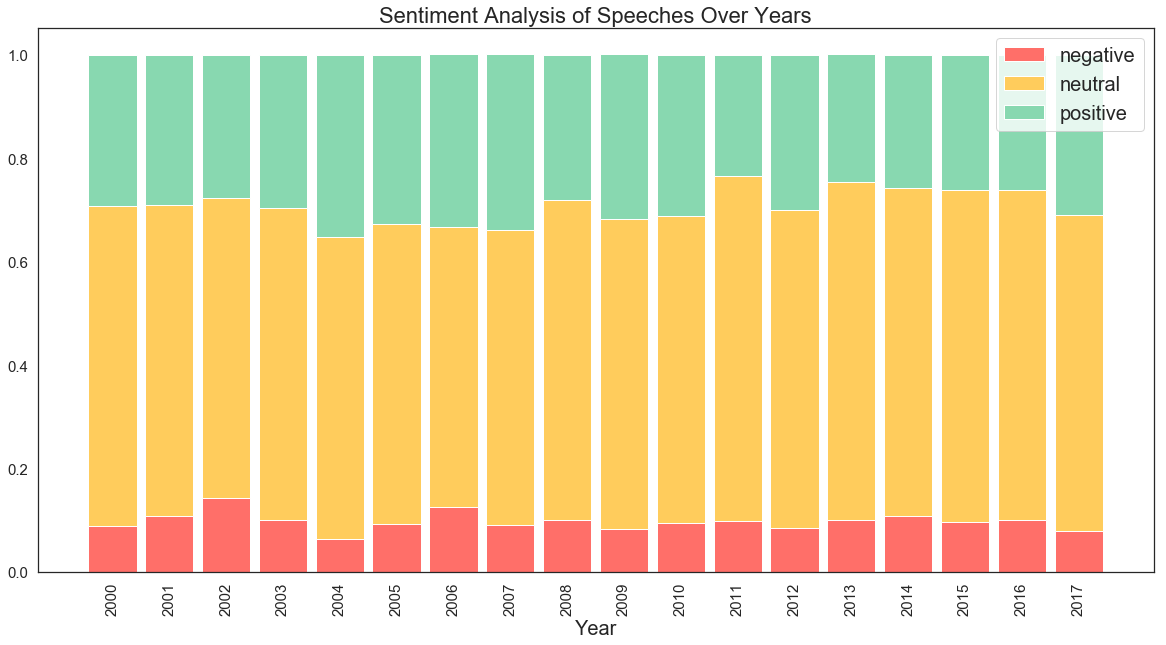

In [42]:
plt.figure(figsize=(20,10))
plt.bar(x_years, neg_values, color='#ff6f69', edgecolor='white', width=barWidth, label = "negative")
plt.bar(x_years, neu_values, bottom = neg_values ,color='#ffcc5c', edgecolor='white', width=barWidth, label = "neutral")
plt.bar(x_years, pos_values, bottom = main_bottom ,color='#88d8b0', edgecolor='white', width=barWidth, label = "positive")
# plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.legend(prop={'size': 20})
plt.title("Sentiment Analysis of Speeches Over Years", fontsize=22)
plt.xticks(x_years, fontsize=15)
plt.yticks(fontsize=15);
plt.xticks(rotation=90);
plt.xlabel("Year", fontsize=20)
# plt.savefig('sentiment_analysis.png', bbox_inches='tight', dpi=500)

## When does top words first appear in the speech?

In [14]:
top_10_words = ['development', 'farmer', 'poor', 'youth', 'education', 'employment']

In [15]:
# top_10_words = sorted(unigram_wordcloud.words_, key=unigram_wordcloud.words_.get, reverse=True)[:5]

In [16]:
# (year, word  index)
top_10_words_year_indexes = []

In [17]:
df.head()

,year,speech,speech_bigrams
0,2000,follow free rendering prime minister shri atal...,follow_free free_rendering rendering_prime pri...
1,2001,late release august 15 2001 3 pm s independenc...,late_release release_august august_15 15_2001 ...
2,2002,pib press release 15th august 2002 prime minis...,pib_press press_release release_15th 15th_augu...
3,2003,pib press release 15th august 2003 prime minis...,pib_press press_release release_15th 15th_augu...
4,2004,text prime minister s independence day address...,text_prime prime_minister minister_s s_indepen...


In [18]:
for idx, row in df.iterrows():
    for _word in top_10_words:
        try:
            top_10_words_year_indexes.append((row["year"], _word, row['speech'].index(_word)+1))
        except:
            print(_word, row["year"])

youth 2001
farmer 2002
education 2002
poor 2004
youth 2008
poor 2009
youth 2010


In [19]:
df_dispersion = pd.DataFrame(top_10_words_year_indexes, columns=["year", "word", "index"])

In [22]:
df_dispersion = pd.merge(df_dispersion, df[['year', 'speech_length']], how='left', on = 'year')

In [23]:
df_dispersion['word_location_percent'] = (df_dispersion['index']/df_dispersion['speech_length'])*100.0

In [24]:
x_years = df_dispersion.year.unique()

In [25]:
x_years

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017])

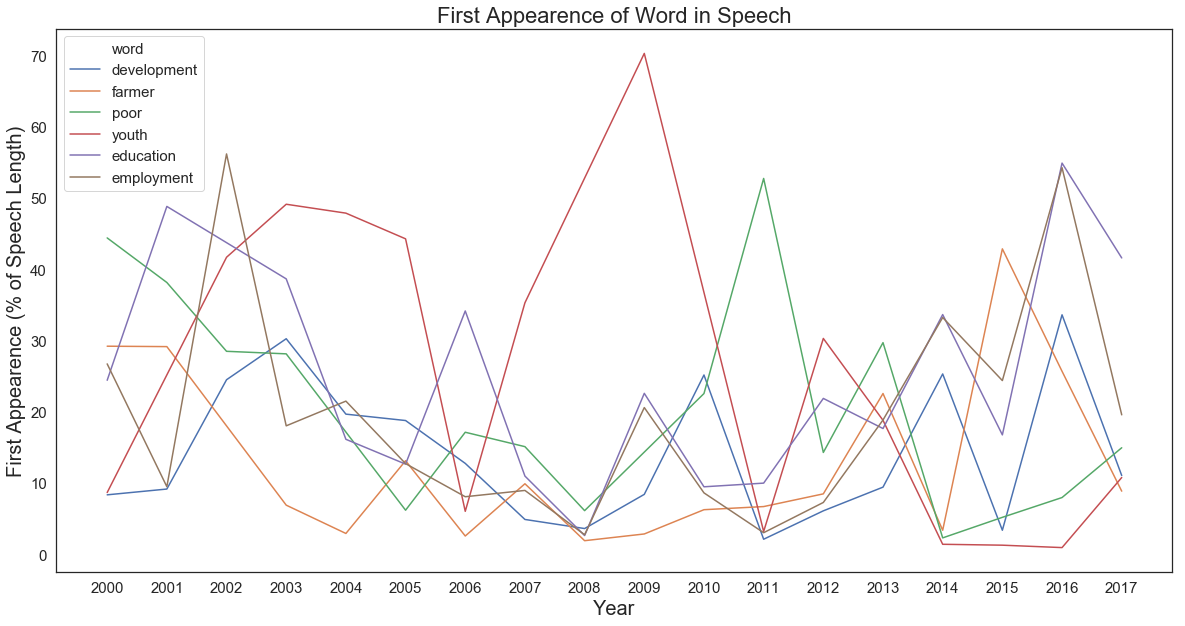

In [27]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x="year", y="word_location_percent", hue="word", data=df_dispersion)
ax.set_title("First Appearence of Word in Speech", fontsize=22)
ax.set_ylabel("First Appearence (% of Speech Length)", fontsize=20);
ax.set_xlabel("Year", fontsize=20);
plt.legend(prop={'size': 15});
# ax.set_xticklabels(x_years, rotation=90, fontsize=15);
plt.xticks(x_years, fontsize=15)
ax.yaxis.set_tick_params(labelsize=15);
plt.savefig('Word_First_Appearence_Percentage.png', bbox_inches='tight', dpi=300)

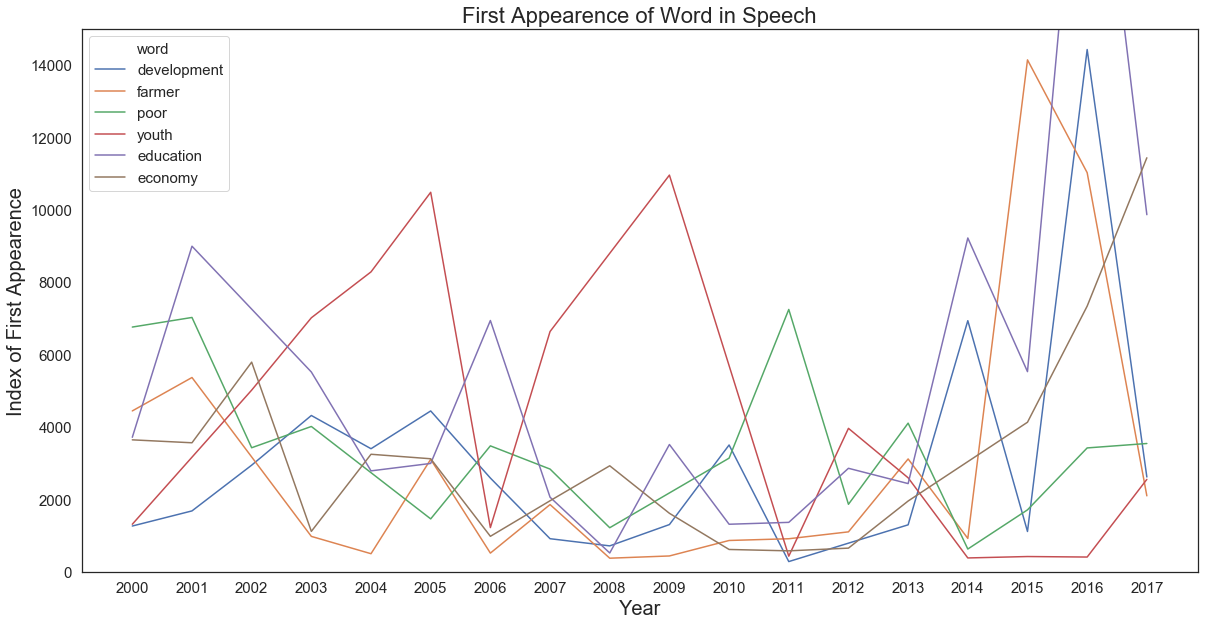

In [97]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x="year", y="index", hue="word", data=df_dispersion)
ax.set(ylim=(0, 15000))
ax.set_title("First Appearence of Word in Speech", fontsize=22)
ax.set_ylabel("Index of First Appearence", fontsize=20);
ax.set_xlabel("Year", fontsize=20);
plt.legend(prop={'size': 15});
# ax.set_xticklabels(x_years, rotation=90, fontsize=15);
plt.xticks(x_years, fontsize=15)
ax.yaxis.set_tick_params(labelsize=15);
plt.savefig('Word_First_Appearence.png', bbox_inches='tight', dpi=300)

## Lexical diversity dispersion plot:

Lexical diversity dispersion plot: lexical diversity lets us what is the percentage of the unique words in the text corpus for example if there are 100 words in the corpus and there are only 20 unique words then lexical diversity is 20/100=0.2. 

In [99]:
def lexical_diversity(text):
    text = text.split(" ")
    return round(len(set(text)) / len(text),2)

In [100]:
df['lexical_diversity'] = df['speech'].apply(lexical_diversity)

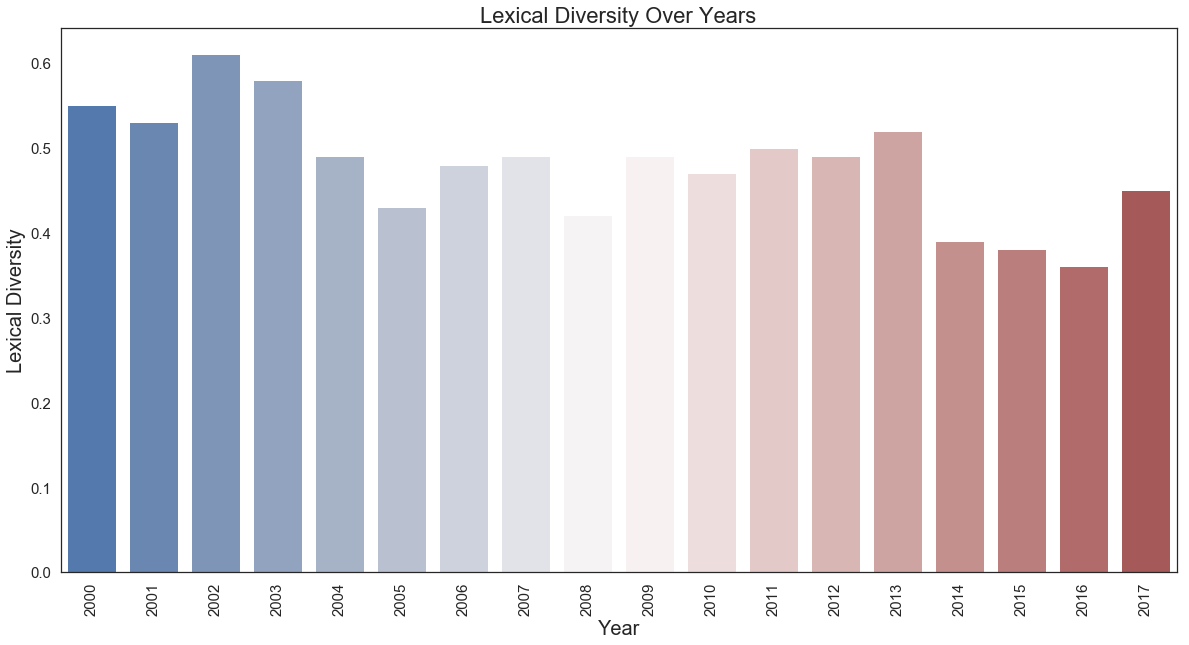

In [104]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x=df.year.values, y=df.lexical_diversity.values, palette="vlag")
ax.set_title("Lexical Diversity Over Years", fontsize=22)
ax.set_ylabel("Lexical Diversity", fontsize=20);
ax.set_xlabel("Year", fontsize=20);
ax.set_xticklabels(df.year.values, rotation=90, fontsize=15);
ax.yaxis.set_tick_params(labelsize=15);
# plt.savefig('lexical_diversity.png', bbox_inches='tight', dpi=500)

## Speeches Similarity with each other using Cosine TF-IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix_train = tfidf_vectorizer.fit_transform(df.speech.values)

In [ ]:
cosine_sims = cosine_similarity(tfidf_matrix_train, tfidf_matrix_train)

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.heatmap(cosine_sims, annot=False, fmt="g", cmap='viridis')
ax.set_xticklabels(df.year.values)
ax.set_yticklabels(df.year.values)
ax.set_title("Similarity Between Speeches", fontsize=22)
ax.set_ylabel("Year", fontsize=20);
ax.set_xlabel("Year", fontsize=20);
ax.set_xticklabels(df.year.values, rotation=90, fontsize=15);
ax.yaxis.set_tick_params(labelsize=15, rotation=0);
plt.savefig('speech_similarity.png', bbox_inches='tight', dpi=500)

## Similarity Heatmap Using Context (word2vec)

In [ ]:
# # (year_1, year_2, similarity)
# similarity_values = []
# for idx, row in df.iterrows():
#     speech_1 = nlp(row["speech"])
#     year_1 = row["year"]
#     for idx2, row2 in df.iterrows():
#         speech_2 = nlp(row2["speech"])
#         year_2 = row2["year"]
#         similarity_values.append((year_1, year_2, speech_1.similarity(speech_2)))

In [ ]:
# df_similarity = pd.DataFrame(similarity_values, columns=["year_1", "year_2", "similarity"])

In [ ]:
# sim_result = df_similarity.pivot(index='year_1', columns='year_2', values='similarity')

In [ ]:
# plt.figure(figsize=(20,10))
# ax = sns.heatmap(sim_result, annot=False, fmt="g", cmap='viridis')
# plt.xticks(rotation=90);

## Topic Modelling of Speeches

In [ ]:
# vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
# data_vectorized = vectorizer.fit_transform(df["speech"].values)

In [ ]:
# lda_model = LatentDirichletAllocation(n_topics=5, max_iter=20, learning_method='online')

In [ ]:
# lda_Z = lda_model.fit_transform(data_vectorized)

In [ ]:
# print(lda_Z.shape)

In [ ]:
# print(lda_Z[0])

In [ ]:
# import pyLDAvis.sklearn
 
# pyLDAvis.enable_notebook()
# panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
# panel